## 数据说明
### 第一部分是用户在商品全集上的移动端行为数据（D）,表名为tianchi_fresh_comp_train_user_2w，包含如下字段：
### 字段 字段说明 提取说明
#### user_id 用户标识 抽样&字段脱敏
#### item_id 商品标识 字段脱敏
#### behavior_type 用户对商品的行为类型 包括浏览、收藏、加购物车、购买，对应取值分别是1、2、3、4。
#### user_geohash 用户位置的空间标识，可以为空 由经纬度通过保密的算法生成
#### item_category 商品分类标识 字段脱敏
#### time 行为时间 精确到小时级别

### 第二个部分是商品子集（P）,表名为tianchi_fresh_comp_train_item_2w，包含如下字段：
### 字段 字段说明 提取说明
#### item_id 商品标识 抽样&字段脱敏
#### item_ geohash 商品位置的空间标识，可以为空 由经纬度通过保密的算法生成
#### item_category 商品分类标识 字段脱敏

## 数据来源
#### 天池：https://tianchi.aliyun.com/competition/entrance/231522/introduction

# 目标
#### 对用户行为生成可交互的可视化图表，并进行一定的商业数据分析

In [1]:
# 统一导入所需的库或模块
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyecharts.options as opts
from pyecharts.charts import Line
from pyecharts.charts import Grid
import numpy as np
from pyecharts.charts import Grid
from pyecharts.charts import Funnel
from pyecharts.charts import Bar

# 一、数据处理

### 导入数据

In [2]:
user_data = pd.read_csv("tianchi_fresh_comp_train_user.csv")
item_data = pd.read_csv("tianchi_fresh_comp_train_item.csv")

### 观察数据

In [3]:
user_data.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time
0,10001082,285259775,1,97lk14c,4076,2014-12-08 18
1,10001082,4368907,1,NaN,5503,2014-12-12 12
2,10001082,53616768,4,NaN,9762,2014-12-02 15
3,10001082,9947871,1,NaN,2825,2014-11-28 20
4,10001082,150720867,1,95qoghe,3200,2014-12-15 08


In [4]:
item_data.head()

,item_id,item_geohash,item_category
0,100002303,NaN,3368
1,100003592,NaN,7995
2,100006838,NaN,12630
3,100008089,NaN,7791
4,100012750,NaN,9614


In [5]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15463110 entries, 0 to 15463109
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   user_id        int64 
 1   item_id        int64 
 2   behavior_type  int64 
 3   user_geohash   object
 4   item_category  int64 
 5   time           object
dtypes: int64(4), object(2)
memory usage: 707.8+ MB


In [6]:
# 看看缺失值有多少
user_data.isnull().sum()

user_id                0
item_id                0
behavior_type          0
user_geohash     8207386
item_category          0
time                   0
dtype: int64

#### user_geohash是用户位置的空间标识，它被脱敏处理了，涉及隐私问题，该项目不做相关分析。其的空缺值无需处理

## 处理数据

### 保留最后出现的相同数据并删除重复数据

In [7]:
user_data.drop_duplicates(keep="last", inplace=True)

### 处理时间列的数据类型
#### user_data中的时间一列，其数据类型为字符串类型，为方便后续处理和分析，需讲他转换成相应的时间类型

In [8]:
user_data["time"] = pd.to_datetime(user_data["time"])
user_data.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time
0,10001082,285259775,1,97lk14c,4076,2014-12-08 18:00:00
1,10001082,4368907,1,NaN,5503,2014-12-12 12:00:00
2,10001082,53616768,4,NaN,9762,2014-12-02 15:00:00
3,10001082,9947871,1,NaN,2825,2014-11-28 20:00:00
4,10001082,150720867,1,95qoghe,3200,2014-12-15 08:00:00


In [9]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15463110 entries, 0 to 15463109
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   user_id        int64         
 1   item_id        int64         
 2   behavior_type  int64         
 3   user_geohash   object        
 4   item_category  int64         
 5   time           datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 707.8+ MB


### 将time列的内容拆分开，以便后续分析

In [10]:
user_data["date"] = user_data.time.dt.date
user_data["month"] = user_data.time.dt.month
user_data["hour"] = user_data.time.dt.hour

In [11]:
user_data.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time,date,month,hour
0,10001082,285259775,1,97lk14c,4076,2014-12-08 18:00:00,2014-12-08,12,18
1,10001082,4368907,1,NaN,5503,2014-12-12 12:00:00,2014-12-12,12,12
2,10001082,53616768,4,NaN,9762,2014-12-02 15:00:00,2014-12-02,12,15
3,10001082,9947871,1,NaN,2825,2014-11-28 20:00:00,2014-11-28,11,20
4,10001082,150720867,1,95qoghe,3200,2014-12-15 08:00:00,2014-12-15,12,8


### 转换数据类型
#### 对于user_id、item_id、behavior_type、item_category这些数据都不应该被是整数类型而应该作为字符串类型

In [12]:
user_data["user_id"] = user_data["user_id"].astype(str)
user_data["item_id"] = user_data["item_id"].astype(str)
user_data["behavior_type"] = user_data["behavior_type"].astype(str)
user_data["item_category"] = user_data["item_category"].astype(str)

In [13]:
user_data = user_data.drop(["user_geohash"], axis=1)

In [14]:
user_data.head()

,user_id,item_id,behavior_type,item_category,time,date,month,hour
0,10001082,285259775,1,4076,2014-12-08 18:00:00,2014-12-08,12,18
1,10001082,4368907,1,5503,2014-12-12 12:00:00,2014-12-12,12,12
2,10001082,53616768,4,9762,2014-12-02 15:00:00,2014-12-02,12,15
3,10001082,9947871,1,2825,2014-11-28 20:00:00,2014-11-28,11,20
4,10001082,150720867,1,3200,2014-12-15 08:00:00,2014-12-15,12,8


# 二、宏观角度分析

### 网站核心流量指标的计算分析

#### 即 计算分析每日PV (Page View): 总浏览量、UV (Unique Visitor): 总访客数。计算 user_id 的去重总数以及人均浏览次数： PV / UV。

In [15]:
day_pv = user_data[user_data["behavior_type"]=="1"].groupby("date")["behavior_type"].count()

In [16]:
day_uv = user_data[user_data["behavior_type"]=="1"].groupby("date")["user_id"].nunique()

In [17]:
# 每日人均浏览次数
pv_uv = day_pv/day_uv

In [66]:
# 创建图表对象
line_1 = (
    Line(init_opts=opts.InitOpts(width="1000px", height="500px"))
)
# 添加x轴数据
attr = list(day_pv.index)
line_1.add_xaxis(attr)
# 添加主y轴数据
line_1.add_yaxis(
    series_name="pv",
    y_axis=day_pv,
    label_opts=opts.LabelOpts(is_show=False)
)
# 添加次y轴
line_1.extend_axis(
    yaxis=opts.AxisOpts(
        name="uv",
        type_="value",
        min_=0,
        max_=max(day_uv) * 1.5,
        interval=0.5, 
        axislabel_opts=opts.LabelOpts(formatter="{value} 万人"),
    )
)
# 添加次y轴数据
line_1.add_yaxis(
    series_name="uv",
    y_axis=day_uv,
    label_opts=opts.LabelOpts(is_show=False),
    yaxis_index=1,
    linestyle_opts=opts.LineStyleOpts(color="#FF0000") # 设置不同颜色
)
# 全局选项设置
line_1.set_global_opts(
    # 标题设置
    title_opts=opts.TitleOpts(
        title="每日 PV 与 UV 趋势对比图",
        subtitle="展示用户浏览量和独立访客数随时间的变化",
        pos_left="center" # 标题居中
    ),
    toolbox_opts=opts.ToolboxOpts(is_show=True),
     tooltip_opts=opts.TooltipOpts(    # 提示框：鼠标悬停在数据点上时显示详细信息
        is_show=True,
        trigger="axis",        
        axis_pointer_type="cross"
     ),
    xaxis_opts=opts.AxisOpts(
        type_="category",       # X 轴类型为分类轴
        name="日期",             # X 轴名称
    ),
    # 主y轴设置
    yaxis_opts=opts.AxisOpts(
        name="PV (万次)",        
        type_="value",          
        min_=0,                 
        max_=max(day_pv) * 1.5, 
        interval=5,             # 刻度间隔
        axislabel_opts=opts.LabelOpts(formatter="{value} 万次"), # 刻度格式化
        axistick_opts=opts.AxisTickOpts(is_show=True), # 显示刻度线
        splitline_opts=opts.SplitLineOpts(is_show=True), # 显示网格线
    ),
    # 图例配置
    legend_opts=opts.LegendOpts(is_show=True, pos_top="50px"),
)
# 图表渲染预加载
line_1.load_javascript()

In [67]:
# 图表渲染
line_1.render_notebook()

### 对人均浏览次数进行可视化分析

In [68]:
v_1=pv_uv
attr=list(pv_uv.index)
line_2 = (
    Line()
    .add_xaxis(xaxis_data=attr) # 设置x轴
    .add_yaxis("人均浏览次数", v_1, label_opts=opts.LabelOpts(is_show=False))
    .set_global_opts(title_opts=opts.TitleOpts(title="每日人均浏览量"))
)
# 图表渲染预加载
line_2.load_javascript()

In [69]:
# 图表渲染
line_2.render_notebook()

## 基于AARRR模型的用户分析

### 1、用户获取分析

In [22]:
print(f"原始数据总行数: {len(user_data)}")
# 计算user_id相同的重复行数量
duplicate_rows_count = user_data.duplicated().sum()
print(f"完全相同的重复行数量: {duplicate_rows_count}")
print(f"重复行占总行数的比例: {duplicate_rows_count / len(user_data):.4%}")

原始数据总行数: 15463110
完全相同的重复行数量: 3677190
重复行占总行数的比例: 23.7804%


#### 寻找每一个用户第一次活跃的情况

In [23]:
first_active_user_data = user_data.groupby("user_id")["time"].min()
df_user_first_active = first_active_user_data.reset_index() # 将索引变回列
df_user_first_active.rename(columns={'time': 'first_active_time'}, inplace=True)
df_user_first_active['active_date'] = df_user_first_active['first_active_time'].dt.date
# 按照active_date进行分组
daily_new_user_counts = df_user_first_active.groupby('active_date').size()
# 将结果转换为 DataFrame，并重命名列
df_daily_new_user = daily_new_user_counts.reset_index(name='new_user_count')
print("每日新增活跃用户数 DataFrame:")
print(df_daily_new_user.head())

每日新增活跃用户数 DataFrame:
  active_date  new_user_count
0  2014-11-18           12534
1  2014-11-19            2548
2  2014-11-20            1191
3  2014-11-21             700
4  2014-11-22             498


### 2、用户激活分析

In [24]:
merged_data = pd.merge(
    user_data,
    df_user_first_active,
    on="user_id",
    how="left"
)
merged_data.head()

,user_id,item_id,behavior_type,item_category,time,date,month,hour,first_active_time,active_date
0,10001082,285259775,1,4076,2014-12-08 18:00:00,2014-12-08,12,18,2014-11-20 19:00:00,2014-11-20
1,10001082,4368907,1,5503,2014-12-12 12:00:00,2014-12-12,12,12,2014-11-20 19:00:00,2014-11-20
2,10001082,53616768,4,9762,2014-12-02 15:00:00,2014-12-02,12,15,2014-11-20 19:00:00,2014-11-20
3,10001082,9947871,1,2825,2014-11-28 20:00:00,2014-11-28,11,20,2014-11-20 19:00:00,2014-11-20
4,10001082,150720867,1,3200,2014-12-15 08:00:00,2014-12-15,12,8,2014-11-20 19:00:00,2014-11-20


In [25]:
# 筛选出激活窗口期中的记录（即：筛选出time值>first_active_time值的记录）
active_window_data = merged_data[merged_data["time"] >= merged_data["first_active_time"]].copy()
# 定义激活窗口期为7天（即7天内存在活跃记录都算进入窗口用户）
active_window_end_date = active_window_data["first_active_time"] + pd.Timedelta(days=7)
# 判断用户活跃行为是否在窗口期内
active_window_data["in_window"] = active_window_data["time"] < active_window_end_date

#### 为了后续计算用户激活率，并基于对电商业务的理解，我将用户行为收藏、加购物车、购买（即2，3，4）作为激活区间

In [26]:
only_in_active_window_user_data = active_window_data[active_window_data["in_window"]].copy()
meaningful_be = ["3", "4"]
# 判断处于窗口期的用户是否有任意的激活行为
in_windows_enable_user = only_in_active_window_user_data.groupby("user_id").agg(
    is_active=("behavior_type", lambda x: (x.isin(meaningful_be)).any())
).reset_index()
in_windows_enable_user["is_active"] = in_windows_enable_user["is_active"].astype(int)
print("\n部分用户激活状态 (1: 已激活, 0: 未激活)：")
print(in_windows_enable_user.head())


部分用户激活状态 (1: 已激活, 0: 未激活)：
     user_id  is_active
0  100002985          1
1   10001025          0
2   10001082          0
3  100027096          0
4  100029775          0


#### 计算激活率

In [27]:
# 激活率即所有在激活窗口期内的用户，已激活的用户的比例
all_user = len(in_windows_enable_user)
active_user = in_windows_enable_user["is_active"].sum()
if all_user > 0:
    active_rate = active_user / all_user
else:
    active_rate = 0
print(f"\n--- 用户激活分析结果 ---")
print(f"在首次活跃后 7 天内，有 {all_user} 位用户进入了激活窗口。")
print(f"其中有 {active_user} 位用户进行了有意义的行为（收藏/加购物车/购买）。")
print(f"用户激活率 (7日内至少有一次收藏/加购/购买行为): {active_rate:.4f}")


--- 用户激活分析结果 ---
在首次活跃后 7 天内，有 20000 位用户进入了激活窗口。
其中有 15479 位用户进行了有意义的行为（收藏/加购物车/购买）。
用户激活率 (7日内至少有一次收藏/加购/购买行为): 0.7740


#### 观察分析在激活窗口中的用户（成功激活/未激活）他们最喜欢的行为是什么

In [28]:
in_active_window_be_count = only_in_active_window_user_data["behavior_type"].value_counts().reset_index()
print("\n激活窗口内的用户行为分布：")
print(in_active_window_be_count)


激活窗口内的用户行为分布：
  behavior_type    count
0             1  3184251
1             3   144320
2             2   105362
3             4    48501


#### 可以看到，在激活窗口期内的用户，他们最喜欢的行为是浏览

In [29]:
# 对于已激活的用户，他们最喜欢的行为是什么
in_windows_enable_user_id = in_windows_enable_user[in_windows_enable_user["is_active"]==1]["user_id"]
enable_user_be_data = only_in_active_window_user_data[only_in_active_window_user_data["user_id"].isin(in_windows_enable_user_id)]
enable_user_be_count_data = enable_user_be_data["behavior_type"].value_counts().reset_index()
print("\n已激活用户行为分布：")
print(enable_user_be_count_data)


已激活用户行为分布：
  behavior_type    count
0             1  2922071
1             3   144320
2             2    94582
3             4    48501


### 3、用户留存分析

In [30]:
merged_data.rename(columns={"active_date": "cohort_date"}, inplace=True)
merged_data.head()

,user_id,item_id,behavior_type,item_category,time,date,month,hour,first_active_time,cohort_date
0,10001082,285259775,1,4076,2014-12-08 18:00:00,2014-12-08,12,18,2014-11-20 19:00:00,2014-11-20
1,10001082,4368907,1,5503,2014-12-12 12:00:00,2014-12-12,12,12,2014-11-20 19:00:00,2014-11-20
2,10001082,53616768,4,9762,2014-12-02 15:00:00,2014-12-02,12,15,2014-11-20 19:00:00,2014-11-20
3,10001082,9947871,1,2825,2014-11-28 20:00:00,2014-11-28,11,20,2014-11-20 19:00:00,2014-11-20
4,10001082,150720867,1,3200,2014-12-15 08:00:00,2014-12-15,12,8,2014-11-20 19:00:00,2014-11-20


In [31]:
merged_data['date'] = pd.to_datetime(merged_data['date'])
merged_data['cohort_date'] = pd.to_datetime(merged_data['cohort_date'])
merged_data['time'] = pd.to_datetime(merged_data['time'])
merged_data['first_active_time'] = pd.to_datetime(merged_data['first_active_time'])

#### 计算留存天数

In [32]:
merged_data["days_since_first_active"] = (merged_data["date"] - merged_data["cohort_date"]).dt.days
print("用户留存天数")
print(merged_data[['user_id', 'cohort_date', 'date', 'days_since_first_active']].head())

用户留存天数
    user_id cohort_date       date  days_since_first_active
0  10001082  2014-11-20 2014-12-08                       18
1  10001082  2014-11-20 2014-12-12                       22
2  10001082  2014-11-20 2014-12-02                       12
3  10001082  2014-11-20 2014-11-28                        8
4  10001082  2014-11-20 2014-12-15                       25


In [33]:
# 不同cohort_date的用户中不同留存天数的用户数量
cohort_retention = merged_data.groupby(["cohort_date", "days_since_first_active"])["user_id"].nunique().reset_index()
cohort_retention.rename(columns={'user_id': 'retained_users'}, inplace=True)
# 每个cohort_date的总用户数
cohort_user_counts = df_user_first_active.groupby("active_date")["user_id"].nunique().reset_index()
cohort_user_counts.rename(columns={"user_id": "cohort_user_counts"}, inplace=True)
cohort_user_counts.rename(columns={"active_date": "cohort_date"}, inplace=True)
cohort_user_counts.head()
cohort_user_counts["cohort_date"] = pd.to_datetime(cohort_user_counts['cohort_date'])

# 合并数据
cohort_analysis_data = pd.merge(
    cohort_retention,
    cohort_user_counts,
    on="cohort_date",
    how="left"
)
# 计算留存率
cohort_analysis_data['retention_rate'] = cohort_analysis_data['retained_users'] / cohort_analysis_data['cohort_user_counts']
print("\n用户留存率：")
print(cohort_analysis_data.head())


用户留存率：
  cohort_date  days_since_first_active  retained_users  cohort_user_counts  \
0  2014-11-18                        0           12534               12534   
1  2014-11-18                        1           10049               12534   
2  2014-11-18                        2            9783               12534   
3  2014-11-18                        3            9455               12534   
4  2014-11-18                        4            9243               12534   

   retention_rate  
0        1.000000  
1        0.801739  
2        0.780517  
3        0.754348  
4        0.737434  


#### 数据表透视和可视化分析

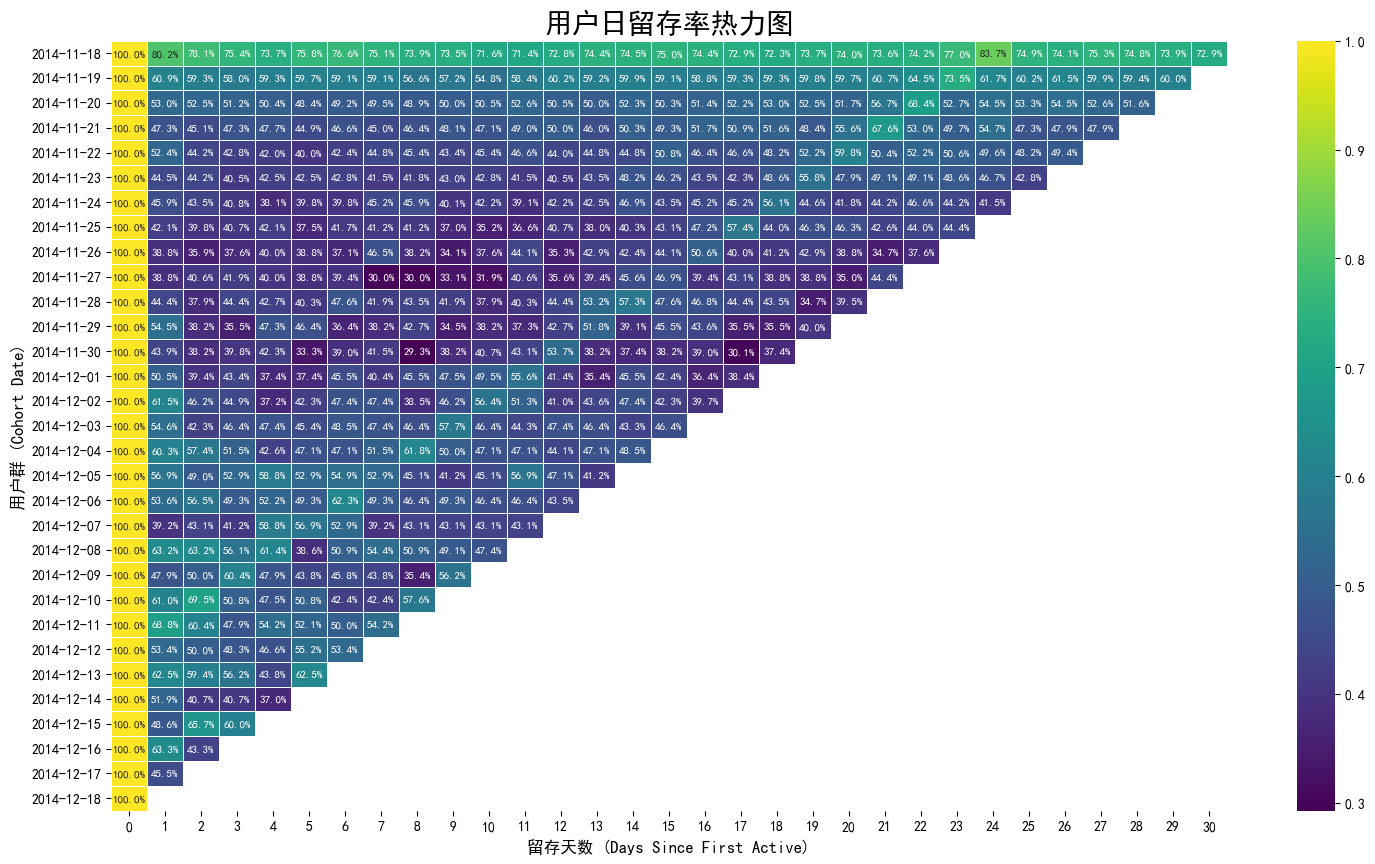

In [34]:
# 建立留存率矩阵
cohort_matrix = cohort_analysis_data.pivot_table(
    index="cohort_date",
    columns="days_since_first_active",
    values="retention_rate"
)
cohort_matrix.index = cohort_matrix.index.strftime('%Y-%m-%d')
# 建立可视化热力图
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(18, 10))
plt.title('用户日留存率热力图', fontsize=20)
ax = sns.heatmap(
    data=cohort_matrix,
    annot=True,
    fmt='.1%',
    cmap='viridis',
    linewidths=.5,
    annot_kws={"size": 8}
)
ax.set_xlabel('留存天数 (Days Since First Active)', fontsize=12)
ax.set_ylabel('用户群 (Cohort Date)', fontsize=12)
plt.show()

#### 绘制留存曲线图
#### 根据数据集我们知道，该数据集包含了双12期间的用户行为记录，另外根据热力图可以看到11.18号的用户各个留存天数的留存率都很高，再有看到11.26、11.27、11.29的各个留存天数的留存率都很低。因此我们选择11.18、11.26、11.27、11.29、12.11用户群来绘制留存曲线图

In [35]:
cohort_matrix.head()

days_since_first_active,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
cohort_date,,,,,,,,,,,,,,,,,,,,,
2014-11-18,1.0,0.801739,0.780517,0.754348,0.737434,0.758417,0.766076,0.750678,0.739189,0.734961,...,0.736078,0.741742,0.770305,0.837163,0.749003,0.741344,0.753072,0.748045,0.738790,0.729057
2014-11-19,1.0,0.608713,0.593407,0.580063,0.592622,0.597331,0.591444,0.591444,0.565542,0.572214,...,0.606750,0.645212,0.734694,0.616562,0.601648,0.614992,0.598901,0.594192,0.600471,NaN
2014-11-20,1.0,0.529807,0.524769,0.512175,0.503778,0.483627,0.492024,0.495382,0.488665,0.499580,...,0.566751,0.684299,0.527288,0.544920,0.533165,0.544920,0.525609,0.515533,NaN,NaN
2014-11-21,1.0,0.472857,0.451429,0.472857,0.477143,0.448571,0.465714,0.450000,0.464286,0.481429,...,0.675714,0.530000,0.497143,0.547143,0.472857,0.478571,0.478571,NaN,NaN,NaN
2014-11-22,1.0,0.524096,0.441767,0.427711,0.419679,0.399598,0.423695,0.447791,0.453815,0.433735,...,0.504016,0.522088,0.506024,0.495984,0.481928,0.493976,NaN,NaN,NaN,NaN


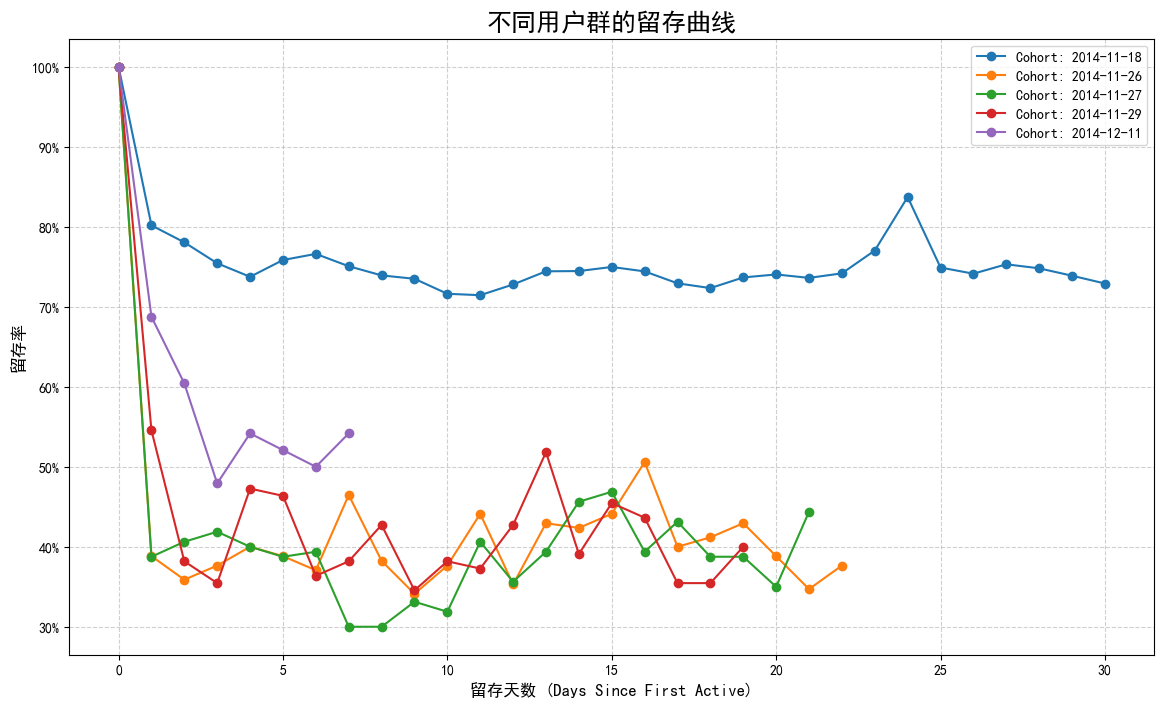

In [36]:
import matplotlib.ticker as mticker
selected_cohorts = ['2014-11-18', '2014-11-26', '2014-11-27', '2014-11-29', '2014-12-11']
plt.figure(figsize=(14, 8))

for cohort in selected_cohorts:
    cohort_df = cohort_matrix.loc[cohort].T.reset_index()
    cohort_df.columns = ['days_since_first_active', 'retention_rate']

    plt.plot(
        cohort_df['days_since_first_active'],
        cohort_df['retention_rate'],
        marker='o', # 在数据点上添加标记
        linestyle='-', # 使用实线连接
        label=f'Cohort: {cohort}' # 图例标签
    )

# 设置图表样式
plt.title('不同用户群的留存曲线', fontsize=18)
plt.xlabel('留存天数 (Days Since First Active)', fontsize=12)
plt.ylabel('留存率', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))

plt.show()

### 4、转化与流失分析

#### 考虑到数据集中双12期间（12.11-12.13）用户行为数据与平时差异较大，因此考虑分开来进行转化与流失分析以及制作漏斗图

In [37]:
user_data['date'] = pd.to_datetime(user_data['date'])

In [38]:
active_day_str_list = ["2014-12-11", "2014-12-12", "2014-12-13"]
active_day_dates = pd.to_datetime(active_day_str_list)
active_day = user_data[user_data["date"].isin(active_day_dates)]
daily = user_data[~user_data["date"].isin(active_day_dates)]

### 日常期间的转化流失分析

In [39]:
# 日常期间各阶段用户数
total_users = daily["user_id"].count()
browsing_users = daily[daily["behavior_type"]=="1"]["user_id"].count()
collect_users = daily[daily["behavior_type"]=="2"]["user_id"].count()
add_to_cart_users = daily[daily["behavior_type"]=="3"]["user_id"].count()
purchased_users = daily[daily["behavior_type"]=="4"]["user_id"].count()

funnel_data = [
    ['总用户', total_users],
    ['浏览用户', browsing_users],
    ['收藏用户', collect_users],
    ['加购用户', add_to_cart_users],
    ['购买用户', purchased_users]
]
funnel_data = [[item[0], int(item[1])] for item in funnel_data]
funnel_data

[['总用户', 13334879],
 ['浏览用户', 12213812],
 ['收藏用户', 404266],
 ['加购用户', 543681],
 ['购买用户', 173120]]

In [40]:
# 计算各个阶段的转化率和流失率
loss_stats = []
stages = ["总用户", "浏览用户", "收藏用户", "加购用户", "购买用户"]
stage_values = [v for s,v in funnel_data]
total_rate = stage_values[0] / stage_values[0]
if len(stage_values) > 0:
    
    # 浏览率和浏览流失率
    if stage_values[0] > 0:
        browse_conversion_rate = stage_values[1] / stage_values[0]
        browse_loss_rate = 1 - browse_conversion_rate
        loss_stats.append(f"浏览转化率: {browse_conversion_rate:.4%}")
        loss_stats.append(f"浏览流失率: {browse_loss_rate:.4%}")
    else:
        loss_stats.append(f"浏览转化率: N/A")
        loss_stats.append(f"浏览流失率: N/A")

    # 用户的收藏转化率
    if stage_values[1] > 0:
        Collect_rate = stage_values[2] / stage_values[0]
        loss_stats.append(f"收藏转化率： {Collect_rate:.4%}")
    else:
        loss_stats.append(f"收藏转化率: N/A")

    # 加入购物车用户转化率
    if stage_values[2] > 0:
        addcar_rate = stage_values[3] / stage_values[0]
        loss_stats.append(f"用户的加购物车转化率： {addcar_rate:.4%}")
    else:
        loss_stats.append(f"用户的加购物车转化率: N/A")

    # 用户的购买转化率
    if stage_values[3] > 0:
        purchase_rate = stage_values[4] / stage_values[0]
        loss_stats.append(f"用户的购买率： {addcar_rate:.4%}")
    else:
        loss_stats.append(f"用户的购买率: N/A")
    # 加入购物车和收藏到购买的转化率
    if stage_values[3] > 0:
       Collect_addcar_to_purchase_rate = stage_values[4] / (stage_values[3] + stage_values[2])
       loss_stats.append(f"加入购物车和收藏到购买的转化率： {Collect_addcar_to_purchase_rate:.4%}")
for rate_list in loss_stats:
    print(rate_list)

浏览转化率: 91.5930%
浏览流失率: 8.4070%
收藏转化率： 3.0316%
用户的加购物车转化率： 4.0771%
用户的购买率： 4.0771%
加入购物车和收藏到购买的转化率： 18.2626%


### 绘制漏斗图

In [41]:
# 声明环境类型
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB
a_attr=["浏览","加入购物车","收藏","购买"]
values=[np.around((browsing_users/browsing_users*100),2),
        np.around((add_to_cart_users/browsing_users*100),2),
        np.around((collect_users/browsing_users*100),2),
        np.around((purchased_users/browsing_users*100),2),
       ]

data = [[a_attr[i], values[i]] for i in range(len(a_attr))]
c = (
    Funnel()
    .add(
        series_name="用户转化漏斗图",
        data_pair=data,
        gap=2,
        label_opts=opts.LabelOpts(position="middle", formatter="{a} <br/>{b} : {c}%"),
        itemstyle_opts=opts.ItemStyleOpts(border_color="#fff", border_width=1),
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="日常期间电商用户转化漏斗分析"),
    )
)
c.load_javascript()

In [42]:
c.render_notebook()

### 日常（非活动期间）的用户转化分析
#### 从图中可以看到，浏览的用户到购买的转化率只有1.42%，加入购物车和收藏的转化率也只在5%以内，这说明用户绝大部分的行为都是浏览，收藏、加购物车乃至购买行为是少数。
####  加入购物车行为（4.45%）略高于收藏行为（3.31%），说明用户在日常的购物目的性相对较强，更多地将商品作为“待购品”而非“愿望清单”。
### 而根据前面的计算，“加入购物车和收藏到购买的转化率： 18.2626%”。
#### 这意味着在日常（非活动期间）用户在表达了强烈的购买意向（收藏/加入购物车）后，最终有超过80%的用户放弃购买。
### 原因分析：
#### 1、大部分可能的原因：这或许是因为该数据表现的是双12活动前夕的用户行为，用户可能都在等待双12活动来了再进行购买。
#### 2、小部分可能的原因：支付流程中的额外成本（如运费）超出预期，导致用户放弃。购物流程被打断，或用户在最后一刻犹豫不决。也有可能只是“随便看看”，加购/收藏行为本身不代表强烈的购买承诺。
### 可能的解决办法：
#### 可以将因为双12而放弃日常期间购买的用户先除外，优先针对因为其他因素而放弃购买的用户。
#### 1、进行购物车/收藏商品的降价提醒
#### 2、对购物车/收藏商品发出促销通知
#### 3、建立类似遗忘提醒系统：加入购物车/收藏后一定时间内未支付，执行送出小额优惠卷等活动（具体时间需要数据支撑才能得到，该数据集并没有包括关于这种措施的数据）

### 双12活动期间的转化流失分析

In [43]:
# 双12活动期间各阶段用户数
active_total_users = active_day["user_id"].count()
active_browsing_users = active_day[active_day["behavior_type"]=="1"]["user_id"].count()
active_collect_users = active_day[active_day["behavior_type"]=="2"]["user_id"].count()
active_add_to_cart_users = active_day[active_day["behavior_type"]=="3"]["user_id"].count()
active_purchased_users = active_day[active_day["behavior_type"]=="4"]["user_id"].count()

active_funnel_data = [
    ['总用户', active_total_users],
    ['浏览用户', active_browsing_users],
    ['收藏用户', active_collect_users],
    ['加购用户', active_add_to_cart_users],
    ['购买用户', active_purchased_users]
]
active_funnel_data = [[item[0], int(item[1])] for item in active_funnel_data]
active_funnel_data

[['总用户', 2128231],
 ['浏览用户', 1939629],
 ['收藏用户', 51213],
 ['加购用户', 96454],
 ['购买用户', 40935]]

In [44]:
# 加入购物车和收藏对购买的转化率
active_a = active_purchased_users / (active_add_to_cart_users + active_collect_users)
active_a

np.float64(0.277211563856515)

In [45]:
# 声明环境类型
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB
a_attr=["浏览","加入购物车","收藏","购买"]
values=[np.around((active_browsing_users/active_browsing_users*100),2),
        np.around((active_add_to_cart_users/active_browsing_users*100),2),
        np.around((active_collect_users/active_browsing_users*100),2),
        np.around((active_purchased_users/active_browsing_users*100),2),
       ]

active_data = [[a_attr[i], values[i]] for i in range(len(a_attr))]
c = (
    Funnel()
    .add(
        series_name="用户转化漏斗图",
        data_pair=active_data,
        gap=2,
        label_opts=opts.LabelOpts(position="middle", formatter="{a} <br/>{b} : {c}%"),
        itemstyle_opts=opts.ItemStyleOpts(border_color="#fff", border_width=1),
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="双12期间电商用户转化漏斗分析"),
    )
)
c.load_javascript()

In [46]:
c.render_notebook()

In [47]:
Data_analysis_table = pd.read_csv("Data analysis table.csv", encoding='gbk')
Data_analysis_table.head()

C:\Users\阿道夫\AppData\Local\Temp\ipykernel_28276\3821678306.py:1: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  Data_analysis_table = pd.read_csv("Data analysis table.csv", encoding='gbk')


,转化路径,日常期间,双12期间,变化幅度
0,浏览 → 加购,4.52%,4.97%,9.90%
1,浏览 → 收藏,3.22%,2.64%,-18.00%
2,浏览 → 总意向 (加购+收藏),7.74%,7.61%,-1.70%
3,意向 → 购买转化率,19.54%,27.72%,41.90%
4,浏览 → 购买 (最终转化),1.51%,2.11%,39.70%


### 双12期间用户行为转化分析
### 数据汇总
#### 加入购物车4.97%、收藏2.64%、购买2.11%、加入购物车和收藏对购买的转化率27.72%
#### 具体的双12期间用户行为和日常期间用户行为的对比见上方表格
### 分析解读
#### 与普遍认知不同的是，该数据集中表现出“双12活动并没有让用户更多的产生购买兴趣/意向”，双12期间的总意向转化率（7.61%）与日常（7.74%）几乎没有差别。
#### 可以看到，相较于日常期间，双12期间收藏行为转化率具有明显的下降（-18.00%），在日常生活中，我们收藏一个电商商品，大部分代表一种长期的愿望，短期的意向一般会放入购物车。而根据数据显示，在双12期间，用户的收藏率显著下降，这表明用户在活动期间更多的是短期愿望以及购买。
#### 另一方面，在双12期间，用户从收藏/加入购物车到购买的转化率出现了大幅上升（+41.90%），这说明在活动期间，用户并不是冲着发现新商品来的而是带着目的来购买的
#### 因此，双12期间，购物车不再是“愿望清单”，而是“待付款清单”。用户的加购行为的含金量极高，每一个加购都代表着一个强烈的、即将进行的购买意向。
### 如上图“不同日期用户各种行为的数据”
#### 可以看到，在双12期间，用户的加入购物车和购买行为大幅增加，而收藏行为的增幅并不大
### 可能的结论和措施
#### 数据表明，当双12到来时，用户更倾向于“找到自己早就准备好的商品，批量的加入购物车，然后直接购买”，而可以从数据中发现，双12活动并没有让更多没有购买准备的用户产生购买兴趣（浏览 → 总意向 (加购+收藏)的转化率，在日常期间为7.74%，而在活动期间为7.61%，变化幅度并不大）
#### 这意味着我们应该在双12之前就开始进行执行相应的营销策略：
#### 在双12活动之前大力举行预热活动，如支付定金的预售活动，或对于那些将商品加入收藏或购物车的用户，为他们推送双12优惠活动通知，帮助用户提前做出决策。

# 三、用户行为分析

In [48]:
only_in_active_window_user_data.head()

,user_id,item_id,behavior_type,item_category,time,date,month,hour,first_active_time,active_date,in_window
5,10001082,97441652,1,10576,2014-11-20 21:00:00,2014-11-20,11,21,2014-11-20 19:00:00,2014-11-20,True
16,10001082,167022568,1,10576,2014-11-20 21:00:00,2014-11-20,11,21,2014-11-20 19:00:00,2014-11-20,True
24,10001082,148581898,1,7229,2014-11-24 17:00:00,2014-11-24,11,17,2014-11-20 19:00:00,2014-11-20,True
40,10001082,262112219,1,9614,2014-11-22 12:00:00,2014-11-22,11,12,2014-11-20 19:00:00,2014-11-20,True
47,10001082,73655468,1,10576,2014-11-20 21:00:00,2014-11-20,11,21,2014-11-20 19:00:00,2014-11-20,True


### 使用折线图对不同日期用户的各种行为的数据生成可视化图表

In [77]:
# 加载库
import pyecharts.options as opts
from pyecharts.charts import Line
from pyecharts.charts import Grid
import numpy as np

# 进行图表制作
# 赋值x轴数据和y轴数据
# 提取 "收藏" (behavior_type == '2') 的用户，并按日期统计数量
y_collect_data = user_data[user_data["behavior_type"] == '2'].groupby("date")["behavior_type"].count()
# 提取 "加购物车" (behavior_type == '3') 的用户，并按日期统计数量
y_add_data = user_data[user_data["behavior_type"] == '3'].groupby("date")["behavior_type"].count()
# 提取 "购买" (behavior_type == '4') 的用户，并按日期统计数量
y_buy_data = user_data[user_data["behavior_type"] == '4'].groupby("date")["behavior_type"].count()

y_uv_data = user_data[user_data["behavior_type"] == '1'].groupby("date")["behavior_type"].count()

In [78]:
# 赋值到x轴y轴所需参数中
v_1 = y_collect_data.values.tolist()
v_2 = y_add_data.values.tolist()
v_3 = y_buy_data.values.tolist()
v_4 = y_uv_data.values.tolist()
attr_a = list(y_collect_data.index)

In [79]:
# 声明环境类型
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB
# 创建图表对象
L = (
    Line()
    .add_xaxis(xaxis_data=attr_a) # 设置x轴
    .add_yaxis("收藏人数", v_1, label_opts=opts.LabelOpts(is_show=False)) # 设置第一条实例数据
    .add_yaxis("加购物车人数", v_2, label_opts=opts.LabelOpts(is_show=False)) # 设置第二条实例数据
    .add_yaxis("购买人数", v_3, label_opts=opts.LabelOpts(is_show=False)) # 设置第三条实例数据
    .add_yaxis("浏览人数", v_4, label_opts=opts.LabelOpts(is_show=False))
    .set_global_opts(title_opts=opts.TitleOpts(title="不同日期用户各种行为的数据")) # 设置全局选项
)
# 进行预加载
L.load_javascript()

In [80]:
# 渲染图表
L.render_notebook()

#### 可以看到很明显的双12期间购买和加购高峰，这和宏观分析中的内容一致

### 日常期间，日均各时段用户行为分析

In [53]:
daily.head()

,user_id,item_id,behavior_type,item_category,time,date,month,hour
0,10001082,285259775,1,4076,2014-12-08 18:00:00,2014-12-08,12,18
2,10001082,53616768,4,9762,2014-12-02 15:00:00,2014-12-02,12,15
3,10001082,9947871,1,2825,2014-11-28 20:00:00,2014-11-28,11,20
4,10001082,150720867,1,3200,2014-12-15 08:00:00,2014-12-15,12,8
5,10001082,97441652,1,10576,2014-11-20 21:00:00,2014-11-20,11,21


In [54]:
# 进行可视化图表制作
uv_h = daily[daily["behavior_type"]=="1"].groupby("hour")["behavior_type"].count()
collect_h = daily[daily["behavior_type"]=="2"].groupby("hour")["behavior_type"].count()
addcar_h = daily[daily["behavior_type"]=="3"].groupby("hour")["behavior_type"].count()
purchased_h = daily[daily["behavior_type"]=="4"].groupby("hour")["behavior_type"].count()

attr_h=list(uv_h.index)
h1=np.around(uv_h.values/3,decimals=0).tolist()
h2=np.around(collect_h.values/3,decimals=0).tolist()
h3=np.around(addcar_h.values/3,decimals=0).tolist()
h4=np.around(purchased_h.values/3,decimals=0).tolist()

# 第一个图
line_h=(
    Line(init_opts=opts.InitOpts(width="1000px", height="500px"))
    .add_xaxis(xaxis_data=attr_h)
    .add_yaxis(
        "收藏人数",
        h2,
        label_opts=opts.LabelOpts(is_show=False)
    )
    .add_yaxis(
        "加购物车人数",
        h3,
        label_opts=opts.LabelOpts(is_show=False)
    )
    .add_yaxis(
        "购买人数",
        h4,
        label_opts=opts.LabelOpts(is_show=False)
    )
    .set_global_opts(
        xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=15)),
        title_opts=opts.TitleOpts(title="日均各时段日常用户行为",pos_top="48%"),
        legend_opts=opts.LegendOpts(pos_top="48%")
    )
)


# 第二个图
bar_h=(
    Bar()
    .add_xaxis(xaxis_data=attr_h)
    .add_yaxis(
        "浏览人数",
        h1,
        label_opts=opts.LabelOpts(is_show=False)
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="日常浏览数据")
    )
)
ggrid=(
    Grid()
    .add(line_h, grid_opts=opts.GridOpts(pos_top="60%"))
    .add(bar_h, grid_opts=opts.GridOpts(pos_bottom="60%"))
)
# 进行预加载
ggrid.load_javascript()

In [55]:
ggrid.render_notebook()

### 图表分析
#### 如图，在日常期间，每天用户对商品浏览的高峰期一般从晚上19点开始，到22点结束。我们需要在这个时间段之前做完所有的营销措施（促销页面、商品直播准备、优惠方式等等）
#### 活动期间，每日收藏趋势和加购物车人数趋势大致相近：和浏览人数一样，在晚上19点到22点之间。
#### 而对于购买人数，从早上10点开始进入第一个高峰期，一直持续到晚上17点，之后又在21点左右进入第二个高峰期，因此我们需要额外推出措施来抓住早上的这个购买高峰期

### 活动期间，日均用户行为分析

In [60]:
active_day
active_uv_h = active_day[active_day["behavior_type"]=="1"].groupby("hour")["behavior_type"].count()
active_collect_h = active_day[active_day["behavior_type"]=="2"].groupby("hour")["behavior_type"].count()
active_addcar_h = active_day[active_day["behavior_type"]=="3"].groupby("hour")["behavior_type"].count()
active_purchased_h = active_day[active_day["behavior_type"]=="4"].groupby("hour")["behavior_type"].count()

active_attr_h=list(active_uv_h.index)
h1=np.around(active_uv_h.values/3,decimals=0).tolist()
h2=np.around(active_collect_h.values/3,decimals=0).tolist()
h3=np.around(active_addcar_h.values/3,decimals=0).tolist()
h4=np.around(active_purchased_h.values/3,decimals=0).tolist()

# 第一个图
active_line_h=(
    Line(init_opts=opts.InitOpts(width="1000px", height="500px"))
    .add_xaxis(xaxis_data=active_attr_h)
    .add_yaxis(
        "收藏人数",
        h2,
        label_opts=opts.LabelOpts(is_show=False)
    )
    .add_yaxis(
        "加购物车人数",
        h3,
        label_opts=opts.LabelOpts(is_show=False)
    )
    .add_yaxis(
        "购买人数",
        h4,
        label_opts=opts.LabelOpts(is_show=False)
    )
    .set_global_opts(
        xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=15)),
        title_opts=opts.TitleOpts(title="活动期间日均各时段用户行为",pos_top="48%"),
        legend_opts=opts.LegendOpts(pos_top="48%")
    )
)


# 第二个图
active_bar_h=(
    Bar()
    .add_xaxis(xaxis_data=active_attr_h)
    .add_yaxis(
        "浏览人数",
        h1,
        label_opts=opts.LabelOpts(is_show=False)
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="活动期间浏览数据")
    )
)
active_ggrid=(
    Grid()
    .add(active_line_h, grid_opts=opts.GridOpts(pos_top="60%"))
    .add(active_bar_h, grid_opts=opts.GridOpts(pos_bottom="60%"))
)
# 进行预加载
active_ggrid.load_javascript()

In [61]:
active_ggrid.render_notebook()

### 图表分析
#### 如图，相较于日常期间的用户浏览数据，双12活动期间用户的浏览数据，其高峰时间段并没有太多的改变，都是在晚上19点开始在22点开始减退，不过浏览的人数出现了大幅增加。由此我们可以得出：商家在双12期间并没有做出相应的措施来引导用户的浏览行为，这里可以进行改进。
#### 图二，可以发现用户们的收藏、加购物车、购买三个行为都是在凌晨12点到达顶峰，这与日常完全不同，可以看出这大概是由于平台进行了引导。

### 购买率图表

In [64]:
# 活动期间购买率
active_user_numb = active_day.drop_duplicates(['user_id','date', 'hour']).groupby("hour")["user_id"].count()
active_purchased_h_duplicates = active_day[active_day["behavior_type"]=="4"].drop_duplicates(['user_id','date', 'hour']).groupby("hour")["behavior_type"].count()
active_purchased_rate = active_purchased_h_duplicates / active_user_numb
attr_1 = list(active_user_numb.index)
vo_2 = np.around(active_purchased_rate.values,decimals=2) 

# 日常期间购买率
purchased_h_duplicates = daily[daily["behavior_type"]=="4"].drop_duplicates(['user_id','date', 'hour']).groupby("hour")["behavior_type"].count()
daily_user_numb = daily.drop_duplicates(['user_id','date', 'hour']).groupby("hour")["user_id"].count()
daily_purchased_rate = purchased_h_duplicates / daily_user_numb
vi_2 = np.around(daily_purchased_rate.values,decimals=2) 

# 绘制图表
pr = (
    Line()
    .add_xaxis(xaxis_data=attr_1)
    .add_yaxis(
        "活动期间购买率",
        vo_2,
    )
    .add_yaxis(
        "日常期间购买率",
        vi_2,
    )
    .set_global_opts(title_opts=opts.TitleOpts(title="不同时间段的购买率"))
)

pr.load_javascript()                     

In [65]:
pr.render_notebook()

## 图表和数据分析
### 根据不同时期"日均各时段用户行为分析"和"不同时间段的购买率"的图表
### 日常期间：
#### 用户的浏览、加购、收藏等行为高度集中在晚上19:00-22:00的个人休息时间。然而，用户的购买行为却出现了两个高峰：一个是在上午10:00-下午17:00的工作或日间时段，另一个是在晚上21:00左右。
#### 这说明大部分用户倾向于在晚上浏览商品并将有意向的商品加入收藏或购物车，但最终的购买决策是在白天完成的。
#### 这种现象直接导致了意向 → 购买转化率的严重偏低（19.54%），从产生意向到最终决定购买，存在长达12小时以上的时间差，足以让用户的购买冲动冷却或被竞品吸引。
### 日常期间的可行措施：
#### 考虑在晚上浏览高峰期时进行直播带货、商品上新等举措来最大化利用流量高峰，对于购买引导措施，应该考虑顺应用户心理，在早晨10点前进行（推送购买提醒、赠送小额优惠卷、推出特价促销等消息）用于承接用户的购买意愿。
### 大型促销活动期间：
####  双12期间，用户的浏览高峰依然维持在晚间19:00-22:00，但流量峰值远高于日常。这说明虽然大促吸引了海量关注，但用户的浏览习惯并未被轻易改变。与日常行为的割裂不同，双12期间的加购、收藏、特别是购买行为，在凌晨0点出现了一个巨大的、其它时段无法比拟的尖峰。如购买率图表所示，活动期间凌晨12点的购买率是白天的两倍左右。
#### 可能的原因：平台通过“0点开抢”、“限时限量”等营销策略，成功地为用户设定了一个“行动终点线”。这与用户“不想错过最低价”的心理完美契合，将分散在一天中不同时段的购买力，高度压缩并集中在0点释放。这直接导致浏览和购买在时间上高度同步，决策路径变短，最终导致“意向-决策转化率”从19.5%大幅提升至27.7%。
### 活动期间的可行措施：
#### 保证货物供应完备、服务器流畅、客服资源等提前规划部署，为用户提供一个流畅、放心的购买体验。在12点前就进行活动预热（如直播发放优惠卷、定金支付等）。

## 活动结束后的用户行为

In [85]:
after_active_uv_d = user_data[user_data["behavior_type"]=="1"].groupby("date")["behavior_type"].count()

attr_a = list(y_collect_data.index)

h4 = after_active_uv_d.values.tolist()

after_active_l_d=(
    Line()
    .add_xaxis(xaxis_data=attr_a)
    .add_yaxis(
        "浏览人数",
        h4,
        label_opts=opts.LabelOpts(is_show=False)
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="活动后每日浏览数据")
    )
)

# 进行预加载
after_active_l_d.load_javascript()

In [86]:
after_active_l_d.render_notebook()

#### 可以看到，在活动之后虽然浏览量还处于较高值，但是浏览量每天都在下降。这段时间如果继续大力进行售卖类的营销活动可能会招致用户的不满，这段时间的运营重点应该从交易类转向关系维护等方面。